In [1]:
from tools_harassment import * 
from transformer_class_SMOTE import *
from models import *
import torch 
from scipy.stats import ortho_group  # Requires version 0.18 of scipy
import gc
from imblearn.over_sampling import SMOTE
import pandas as pd
import gc
import seaborn 


keras.losses.focal_loss=keras.losses.MSE
keras.losses.focal_loss_fixed=keras.losses.MSE

n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('There are',torch.cuda.device_count(),'GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


keys=["commenting", "support", "denying", "questioning"]


dict_cl=dict()
dict_cl[0]="NonH"
dict_cl[1]="IndirectH"
dict_cl[2]="PhysicalH"
dict_cl[3]="SexualH"

#sdqc
d_lab=dict()
d_lab["NonH"]=0
d_lab["IndirectH"]=1
d_lab["PhysicalH"]=2
d_lab["SexualH"]=3

path="../../Datasets/CSV_Harassment/"
train =pd.read_csv(path + "train_format.csv")
val=pd.read_csv(path + "val_format.csv")
test=pd.read_csv(path + "test_format.csv")

keys=["NonH", "IndirectH", "PhysicalH", "SexualH"]

stoplist = stopwords.words("english")
puntos='!?."()[´]“<>¡¿-/;:=_”@#.'


Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1060 6GB


In [2]:
def cm_norma(matrix):
    return matrix/matrix.sum(axis=-1, keepdims=True)
    
    
def predict_data(trained, x_train, x_val, x_test, etiq, etiq_v, etiq_t, name_model):
    etiq = etiq.astype("int")
    trainPredict = trained.predict(x_train, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq, trainPredict)  
    f1=f1_score(etiq, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq, trainPredict))
    """print ("")
    print ("Accuracy sobre Train", name_model, ":",acc)  
    print ("F1-score None sobre Train", name_model, ":",f1)
    print ("F1-score macro sobre Train", name_model, ":",f1_ma)"""
    ########################################
    trainPredict = trained.predict(x_val, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc= accuracy_score(etiq_v, trainPredict)  
    f1=f1_score(etiq_v, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma=f1_score(etiq_v, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    #matriz=normalize(confusion_matrix(etiq_v, trainPredict))
    """print ("")
    print ("Accuracy sobre Val", name_model, ":",acc)  
    print ("F1-score None sobre Val", name_model, ":",f1)
    print ("F1-score macro sobre Val", name_model, ":",f1_ma)
    ########################################"""
    trainPredict = trained.predict(x_test, batch_size=32)
    trainPredict=[np.argmax(pred) for pred in trainPredict]
    acc_t= accuracy_score(etiq_t, trainPredict)  
    f1_t=f1_score(etiq_t, trainPredict, average=None)  # labels=np.unique(trainPredict)
    f1_ma_t=f1_score(etiq_t, trainPredict, average='macro')  # labels=np.unique(trainPredict)
    matriz_t=normalize(confusion_matrix(etiq_t, trainPredict))
    print ("")
    print ("Accuracy sobre Test", name_model, ":",acc_t)  
    print ("F1-score None sobre Test", name_model, ":",f1_t)
    print ("F1-score macro sobre Test", name_model, ":",f1_ma_t)
    
    return f1_ma_t, f1_t, acc_t, matriz_t

def cleaner(post): 
    s= re.sub(r"http\S+", " html ", post)   ##########elimina http    
    s= re.sub(r'#\w+ ?', " hashtag ", s) ########3
    s= re.sub(r'@\w+ ?', " user ", s)##############    
    s= s.lower()
    s=emoji_pattern.sub(r'', s)
    s=re.sub(r"'\b", " ' ", s)
    s=re.sub(r"\b'\b", " ' ", s)
    s=re.sub(r"“\b", " “ ", s)
    s=re.sub(r"\b’", " ’ ", s)
    s=re.sub(r"‘\b", " ‘ ", s)
    s=re.sub(r"\b’\b", " ‘ ", s)
    s = re.sub(r"-", " - ", s)
    s = re.sub(r"\(", " ", s)
    s = re.sub(r"\)", " ", s)
    s = re.sub(r"\?", " ? ", s)    
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"' ", " ' ", s)
    s = re.sub(r" '", " ' ", s)
    s = re.sub(r"\!", " ! ", s)
    s=re.sub("[\.]+", " . ", s)
    s=re.sub("[\,]+", " , ", s)
    s=re.sub("[\;]+", " ; ", s)
    s=re.sub("[\:]+", " : ", s)
    s=re.sub('[\"]+', ' " ', s)
    s=re.sub(r'\b[0-9]\b', " number ",  s)
    s=re.sub(r'\b[0-9]*[0-9]\b', " number ",  s)    
    s=re.sub(r'\b”', ' " ', s)
    sl= list(s.split())
    sl_2=[]
    for wd in sl:
        try: 
            q=token_2_idx[wd]
            sl_2.append(wd)
        except:
            try: 
                if stemmer.stem(wd) in token_2_idx.keys():
                    sl_2.append(stemmer.stem(wd))
                elif lemmatizer.lemmatize(wd) in token_2_idx.keys():
                    sl_2.append(lemmatizer.lemmatize(wd))
                else:
                    sl_2.append(wd)
            except:
                sl_2.append(wd)
    sl=sl_2
    s=' '.join([word for word in sl])# if word not in stoplist])
    return s, sl

In [3]:
import os 
embeddings_index = {}
token_2_idx={}
idx_2_token={}
f = open(os.path.join("../../Datasets/glove.twitter.27B.200d.txt"))#'glove.twitter.27B.100d.txt'))
i=0
for line in f:
    values = line.split()
    if len(values)>200:
        word = values[0]
    else:
        #print ("Problema con line ", line)
        continue
    token_2_idx[word]=i
    idx_2_token[i]=word
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    i+=1
f.close()

print('Se encontraron %s terminos con sus vectores de embedding.' % len(embeddings_index))

Se encontraron 1193513 terminos con sus vectores de embedding.


In [4]:
MAX_LEN = 37
emb=200
EMB_matrix=np.zeros((len(token_2_idx.keys()), emb))
for i in range(len(token_2_idx.keys())):
    EMB_matrix[i]=embeddings_index[idx_2_token[i]]
    
transformer = Normalizer().fit(EMB_matrix) 
EMB_matrix=transformer.transform(EMB_matrix)
EMB_matrix.shape

(1193513, 200)

In [5]:
ids_train=train['tweet_id']
tws_train=train['Tweet']
labels_train=[d_lab[lb] for lb in train['Label']]
#class_weights= compute_class_weight('balanced', np.unique(labels_train), labels_train)
class_weights= [1.0, 1.0, 1.0, 1.0]
#class_weights=np.asarray(class_weights)
print ("Pesos de clases:", class_weights)

ids_val=val['tweet_id']
tws_val=val['Tweet']
labels_val=[d_lab[lb] for lb in val['Label']]

ids_test=test['tweet_id']
tws_test=test['Tweet']
labels_test=[d_lab[lb] for lb in test['Label']]

Pesos de clases: [1.0, 1.0, 1.0, 1.0]


In [6]:
sentences = tws_train
n_labels = np.asarray(labels_train)
y_train=to_categorical(n_labels,num_classes=4)

sentences_val = tws_val
n_labels_val = np.array(labels_val)
y_val=to_categorical(n_labels_val,num_classes=4)

sentences_test = tws_test
n_labels_test = np.array(labels_test)
y_test=to_categorical(n_labels_test,num_classes=4)

In [7]:
input_ids=[]
for sent in sentences:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids.append(encoded_sent) 
    
input_ids_val=[]
for sent in sentences_val:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_val.append(encoded_sent) 

input_ids_test=[]
for sent in sentences_test:
    encoded_sent=[]
    for wd in cleaner(sent)[1]:
        try:
            encoded_sent.append(token_2_idx[wd])
        except:
            continue
    input_ids_test.append(encoded_sent) 
    

In [8]:
input_ids = pad_sequences(input_ids,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_val = pad_sequences(input_ids_val,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test,maxlen=MAX_LEN,dtype="long",value=0, truncating="post", padding="post")

shape=np.asarray(input_ids).shape
shape_val=np.asarray(input_ids_val).shape
shape_test=np.asarray(input_ids_test).shape

In [9]:
x_train=np.zeros((shape[0], emb))
i=0
for in_id in input_ids:
    vector=np.zeros(emb)
    n = np.sum(in_id != 0)
    if n==0:
        x_train[i]=vector
        i+=1
        continue
        
    else:
        for idv in in_id:
            if idv!=0:
                vector+=EMB_matrix[idv]
        x_train[i]=(vector/n)
        i+=1   
    
x_val=np.zeros((shape_val[0], emb))
i=0
for in_id in input_ids_val:
    vector=np.zeros(emb)
    n = np.sum(in_id != 0)
    for idv in in_id:
        if idv!=0:
            vector+=EMB_matrix[idv]
    x_val[i]=(vector/n)
    i+=1  
    
x_test=np.zeros((shape_test[0], emb))
i=0
for in_id in input_ids_test:
    vector=np.zeros(emb)
    n = np.sum(in_id != 0)
    for idv in in_id:
        if idv!=0:
            vector+=EMB_matrix[idv]
    x_test[i]=(vector/n)
    i+=1  

In [10]:
x_train.shape

(6374, 200)

In [11]:
x_test.shape

(2123, 200)

In [12]:
def predecir_modelos(bs,predichos_all):  #best fit
    temp=predichos_all.copy()
    final=[np.argmax(pred) for pred in temp]  
    confianzas=[temp[i][final[i]] for i in range(len(final))]
    predichos_new=[]
    for i in range(len(temp)):
        indice=final[i]%4
        predichos_new.append(int(indice))
    return predichos_new,final,confianzas    

def predecir_modelos_norm(bs,predichos_all):  #normalizado
    temp=predichos_all.copy()
    final=[]
    confianzas=[]
    for pred in temp:   
        aux=np.ones(4)
        for i in range(1,6): #for machine pred
            sub=pred[(4*(i-1)):(4*i)]
            aux=aux*np.asarray(sub)
            
        aux=aux/np.sum(aux)
        final.append(np.argmax(aux))
        confianzas.append(aux[np.argmax(aux)])  
           
    predichos_new=[]
    for i in range(len(temp)):
        predichos_new.append(final[i])
    return predichos_new,final,confianzas
    
def predecir_modelos_average(bs,predichos_all): #average
    temp=predichos_all.copy()
    final=[]
    confianzas=[]
    for pred in temp:
        aux=np.zeros(4)
        for i in range(1,6):
            sub=pred[(4*(i-1)):(4*i)]
            aux=aux+np.asarray(sub)
            
        aux=aux/5.0 #dividido en el total de machines
        final.append(np.argmax(aux))
        confianzas.append(aux[np.argmax(aux)])  
           
    predichos_new=[]
    for i in range(len(temp)):
        predichos_new.append(final[i])
    return predichos_new,final,confianzas


In [14]:
def match(objetos,ejemplo):
    i=0
    for obj in objetos:
        if obj==ejemplo:
            return i
        i+=1
        
def data_gen(batch_size,mode, x_train, lab_str_embeddings, index_embeddings):
    x_data=[] 
    y_data=[]
    if mode=='Train':
        max_objs=x_train.shape[0]
        x_list=np.arange(max_objs)
        np.random.shuffle(x_list)        #indices desordenados de seccion train
        objs=ids_train
        labels=etiq     #np.load("matrices/y_train_num_4.npy")
        labels=np.asarray(labels) #+ np.ones(labels.shape),dtype='uint8')
    if mode=='Val':
        max_objs=x_val.shape[0] 
        x_list=np.arange(max_objs)
        x_list=[x+x_train.shape[0] for x in x_list]   
        objs=val['tweet_id']    #df_val['Unnamed: 0'].values        
        labels=np.asarray(etiq_v)     #np.load("matrices/y_val_num_4.npy")
        labels=np.asarray(labels)  
    if mode=='Test':
        max_objs=x_test.shape[0] 
        x_list=np.arange(max_objs)
        x_list=[x+x_train.shape[0]+x_val.shape[0] for x in x_list]
        total=x_train.shape[0]+x_val.shape[0]
        objs=test['tweet_id']
        
    #----------------------------------- COMPLETA MINI BATCHES ----------------------    
    if len(x_list)%batch_size==0:
        n_batches=len(x_list)/batch_size
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
    else:
        n_batches=int(len(x_list)/batch_size)
        resto=int(len(x_list)-n_batches*batch_size)
        to_repeat=batch_size-resto        
        for nb in range(n_batches): 
            x_data.append(x_list[nb*batch_size:(nb+1)*batch_size])
        cola=list(x_list[(nb+1)*batch_size:])
        for i in range(to_repeat):
            indice= np.random.randint(len(x_list))
            cola.append(x_list[indice])
        x_data.append(np.asarray(cola))
        if mode=='Test':
            print ("SE TUVIERON QUE REPETIR", to_repeat, "EJEMPLOS")
            
    #-------------------------------- CONSTRUCCION MINI BATCHES (X,Y)----------------------   
    new_x_data=[] 
    for batch in x_data:
        temp=[]
        for pos in batch:
            temp2=[index_embeddings[pos+5]]  
            temp.append(temp2)
        new_x_data.append(temp)   

    if mode=='Train' or mode=='Val':    
        y_data=[]
        for conjunto in range(len(new_x_data)):
            batch=new_x_data[conjunto]
            temp_y=[]
            for linea in range(len(batch)):
                indice=x_data[conjunto][linea]  #pos
                lab=d_lab[lab_str_embeddings[indice+5]]+1 #labels_train
                temp_y.append([lab])       
            y_data.append(temp_y)
            
        y_data=np.asarray(y_data)
        
    new_x_data=np.asarray(new_x_data)
    #print ("primer batch X.Y", new_x_data[0], y_data[0])
    if mode=='Test':
        for x in new_x_data:
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            yield Batch(src, None, 0)        
    else:          
        for x,y in zip(new_x_data, y_data):
            src = Variable(torch.from_numpy(np.asarray(x)), requires_grad=False)
            har = Variable(torch.from_numpy(np.asarray(y)), requires_grad=False)
            yield Batch(src, har, 0)


def make_model_concat(target, K_list_new, N=2, d_model=768, d_ff=1024, h=4, dropout=0.3, soft=True):  #recibir src_vocab si lo utiliza dummy_Emb
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalText_concat(d_model, dropout)
    if soft:
        print ("Creando modelo con salida Softmax")
        model = EncoderDecoderSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(d_model, K_list_new), c(position)),
            nn.Linear(d_model, 4))
    else:
        print ("")
        print ("Creando modelo con salida Log_softmax")
        model = EncoderDecoderLogSoft(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            nn.Sequential(Dummy_Embeddings(d_model, K_list_new), c(position)),
            nn.Linear(d_model, 4))

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

def run_epoch(data_iter, model, loss_compute, mode):
    if mode=='Test':
        with torch.no_grad():
            start = time.time()
            pred_classes=[]
            for i, batch in enumerate(data_iter):
                #print ("batch.src_mask en run epoch", batch.src_mask)
                out = model.forward(batch.src, batch.src_mask)
                pred_classes.append(out.argmax(dim=-1).numpy())
                #la loss del batch es sobre todos los ejemplos o es promedio en batch?
            return pred_classes
    
    else:
        start = time.time()
        total_learners = 0
        total_datos = 0
        total_loss = 0
        total_acc=0
        total_fm1=0
        total_fs=0
        n_batches = 0
        cm_last=np.zeros((4,4))
        for i, batch in enumerate(data_iter):
            #print ("BATCH\n", i, '\n', batch.src)
            out = model.forward(batch.src, batch.src_mask)
            #print ("OUT DE RUN EPOCH", out)
            loss,acc,f1,cm = loss_compute(out, batch.trg_y, batch.ntokens, mode)
            cm_last+=cm
            f_ma=np.mean(f1)
            total_loss += loss
            total_acc += np.array(acc)
            total_fm1 += np.sum(f1)/4.0    #4 clases (macro)
            total_fs += f1                 #none  
            total_datos += batch.ntokens
            n_batches += 1
        return total_loss/n_batches, torch.from_numpy(np.array(total_acc))/n_batches, torch.from_numpy(np.array(total_fm1))/n_batches, torch.from_numpy(np.array(total_fs))/n_batches, cm_last


def draw(data, ax, label, color="Blues"):
    seaborn.heatmap(data, 
                    xticklabels=label[0], square=True, yticklabels=label[0], vmin=0.0, vmax=1.0, 
                    cbar=False,  cmap=color, ax=ax)

In [16]:

etiq=np.asarray(labels_train)
etiq_v=np.asarray(labels_val)
etiq_t=np.asarray(labels_test)

In [17]:
class SimpleLossComputeFL:
    "A simple loss compute and train function."
    def __init__(self, criterion, opt=None):
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm, mode):
        y_new=(y.float()-torch.ones((y.shape))).int() 
        ac=accuracy_scorer(x, y_new)
        f1=f_scorer(x, y_new)
        cm=compute_confusion_matrix(x, y_new)
        tempa= x.contiguous().view(-1, x.size(-1))
        tempb= y_new.long().contiguous().view(-1)
        loss = self.criterion(tempa, tempb) #/ norm
        if mode!='Test':
            loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()    
        return [loss.data, ac ,f1, cm] #*norm #[0] * norm
        # loss.data[0] * norm

In [18]:
import seaborn 

def draw(data, ax, label, color="Blues"):
    seaborn.heatmap(data, 
                    xticklabels=label[0], square=True, yticklabels=label[0], vmin=0.0, vmax=1.0, 
                    cbar=False,  cmap=color, ax=ax)

In [27]:
def train_5models_smote(e1, e2, x_val, y_val, xfrom, xto, task, num_epochs, c_gama):
    global_accs=[]
    global_fnones=[]
    global_fmacros=[]
    global_cms=[]
    
    predicciones_all=[]
    predicciones_all_val=[]
    predicciones_all_test=[]
    
    best_macro={'F_ma':0.1 , 'Run':0}
    
    if task== 'Stance':
        path='../../Datasets/Models_Stance/SMOTE'
    elif task== 'Harassment':
        path= '../../Datasets/Models_Harassment/SMOTE'
        
    bs=32
    n_machines=5
    
    keys=["NonH", "IndirectH", "PhysicalH", "SexualH"]

    
    for x in range(xfrom,xto + 1):    
        sm = SMOTE(random_state=27, n_jobs=-1, sampling_strategy='not majority')
        x_train_smote, y_train_smote = sm.fit_sample(np.asarray(x_train, dtype='float32'), np.asarray(n_labels, dtype='float32'))


        x_new_train=np.expand_dims(x_train_smote, axis=-1)
        x_new_val=np.expand_dims(x_val, axis=-1)
        x_new_test=np.expand_dims(x_test, axis=-1)

        y_train=to_categorical(y_train_smote,num_classes=4)

        class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_smote), y_train_smote)
        print ("class_weights Training set", class_weights)
            
        
        print ("\n\n -------------------- Entrenando SMOTE exec", x," ------------------- \n\n")
        
        ################# TRANSFORMER    
        print ("\n--------------------------------------------------------")
        print ("Trabajando en predicciones Transformer")
        print ("--------------------------------------------------------\n")
        

        print ("Entrenando Run #", x)
        espacio=[np.ones(emb)]
        Ks= ortho_group.rvs(dim=emb)
        random=np.random.randint(Ks.shape[0], size=4)
        K_list=Ks[random]
        K_list_ext=espacio+list(K_list)
        index_embeddings=[0,1,2,3,4]
        lab_str_embeddings=['','','','','']
        
        
        for i in range(len(x_new_train)):
            clase=dict_cl[y_train_smote[i]]   
            final_bert= x_train_smote[i]

            index_embeddings.append(i+5)
            lab_str_embeddings.append(clase)
            K_list_ext.append(final_bert)
            

        objs_val=val['tweet_id']      #df_val['Unnamed: 0'].values
        objs_test=test['tweet_id']    #np.arange(df_test.shape[0])
        lab_val=val['Label']
        lab_test=test['Label']
        tw_val=val['Tweet']
        tw_test=test['Tweet']
        llaves=np.concatenate([objs_val,objs_test])
        clases=np.concatenate([lab_val,lab_test])
        sent_all=np.concatenate([tw_val,tw_test])   
        
        for num in range(len(llaves)):
            clase=clases[num]
            tw_tr=sent_all[num]
            tokens_valid = cleaner(tw_tr)[1]  #cleaner: raw, no cleaner:augmented version
            
            trans=[]
            for wd in tokens_valid:
                try:
                    trans.append(token_2_idx[wd])
                except:
                    continue
            encoded_tok=trans

            q_glove=len(encoded_tok)
            glove_tok_f=[EMB_matrix[ide] for ide in encoded_tok]
            final=np.sum(glove_tok_f, axis=0)
            if q_glove!=0:
                final_bert=final/q_glove
            else:
                final_bert=np.zeros(emb)

            index_embeddings.append(num+5+train.shape[0])
            lab_str_embeddings.append(clase)
            K_list_ext.append(final_bert)
        

        K_list_new= np.asarray(K_list_ext, dtype='float32')
    
        V = 4
        pesos = torch.from_numpy(class_weights).float()
        criterion = FocalLoss(weights=pesos)
        model = make_model_concat(4, K_list_new, N=2,d_model=emb, d_ff=128, h=4, dropout=0.35)
        model_opt = NoamOpt(model.src_embed[0].d_model,  1, 6000, torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-5))


        for epoch in range(num_epochs):
            model.train()
            DATA=data_gen(bs, 'Train', x_train, lab_str_embeddings, index_embeddings)  
            loss_train, acc_train,fma_train, f_none, cm_train=run_epoch(DATA, model, SimpleLossComputeFL(criterion, model_opt), 'Train')

            model.eval()
            DATA_VAL=data_gen(bs, 'Val', x_train, lab_str_embeddings, index_embeddings)
            loss_val, acc_val,fma_val, f_val_none, cm_val=run_epoch(DATA_VAL, model, SimpleLossComputeFL(criterion, None),'Val')
            if epoch%10==0:
                print ("Epoch",epoch, "\tacc_val: %.3f" % acc_val.numpy(), "\tF-macro_val: %.3f" % fma_val.numpy())

        model.eval()
        print ("Testing run #",x)
        DATA_TEST=data_gen(bs, 'Test', x_train, lab_str_embeddings, index_embeddings)
        predicciones = run_epoch(DATA_TEST, model, SimpleLossComputeFL(criterion, None),'Test')
        predicciones=np.concatenate(predicciones, axis=-1)

        glo_acc=accuracy_score(etiq_t, predicciones[:-21])
        glo_fno=f1_score(etiq_t,predicciones[:-21], average=None)
        glo_fma=f1_score(etiq_t,predicciones[:-21], average='macro')

        glo_cm=confusion_matrix(etiq_t, predicciones[:-21])

        plot_cm(cm_norma(glo_cm),["NonH", "IndirectH", "PhysicalH", "SexualH"],"TEXT SMOTE Transformer ", cmap=c_gama)
        global_accs.append(glo_acc)
        global_fnones.append(glo_fno)
        global_fmacros.append(glo_fma)
        global_cms.append(glo_cm)
        print("Test_ acc:",glo_acc) 
        print("Test_ f1 none:",glo_fno) 
        print("Test_ f1 macro:",glo_fma) 

        if glo_fma>best_macro['F_ma']:
            best_macro['F_ma']=glo_fma
            best_macro['Run']=x                
            print ("\n\nNuevo best encontrado:\n")
            print ("Acc: %.3f" % glo_acc, "\tF1-ma: %.3f" % glo_fma)
            np.set_printoptions(precision=3)
            print ("\tF1-none: ", glo_fno)
                    
    return best_macro, global_accs, global_fnones, global_fmacros, global_cms  
#best_ma, glo_accs, glo_fno, glo_fma, glo_cms

In [20]:
import matplotlib.pyplot as plt 

def plot_cm(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(7, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
    thresh = cm.max() / 2.# if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## SMOTE - Balanced data 

class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 1  ------------------- 



--------------------------------------------------------
Trabajando en predicciones Transformer
--------------------------------------------------------

Entrenando Run # 1
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.112 	F-macro_val: 0.049
Epoch 10 	acc_val: 0.000 	F-macro_val: 0.000
Epoch 20 	acc_val: 0.000 	F-macro_val: 0.000
Testing run # 1
SE TUVIERON QUE REPETIR 21 EJEMPLOS


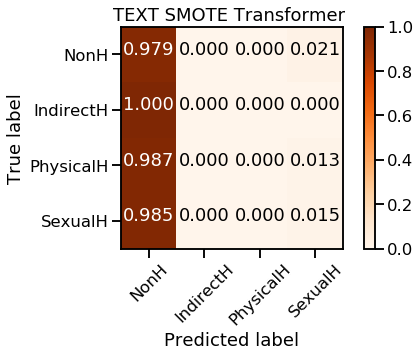

Test_ acc: 0.7409326424870466
Test_ f1 none: [0.85101764 0.         0.         0.02638522]
Test_ f1 macro: 0.21935071583793672


Nuevo best encontrado:

Acc: 0.741 	F1-ma: 0.219
	F1-none:  [0.851 0.    0.    0.026]
class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 2  ------------------- 



--------------------------------------------------------
Trabajando en predicciones Transformer
--------------------------------------------------------

Entrenando Run # 2
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.173 	F-macro_val: 0.072
Epoch 10 	acc_val: 0.012 	F-macro_val: 0.006
Epoch 20 	acc_val: 0.000 	F-macro_val: 0.000
Testing run # 2
SE TUVIERON QUE REPETIR 21 EJEMPLOS


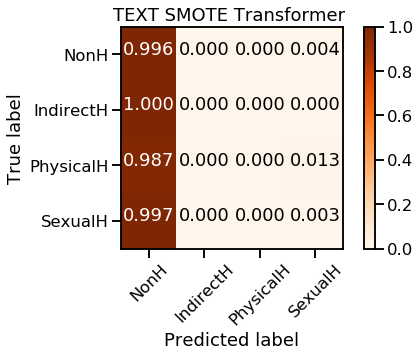

Test_ acc: 0.7517663683466792
Test_ f1 none: [0.858 0.    0.    0.006]
Test_ f1 macro: 0.21604926815386707
class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 3  ------------------- 



--------------------------------------------------------
Trabajando en predicciones Transformer
--------------------------------------------------------

Entrenando Run # 3
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.169 	F-macro_val: 0.071
Epoch 10 	acc_val: 0.008 	F-macro_val: 0.004
Epoch 20 	acc_val: 0.000 	F-macro_val: 0.000
Testing run # 3
SE TUVIERON QUE REPETIR 21 EJEMPLOS


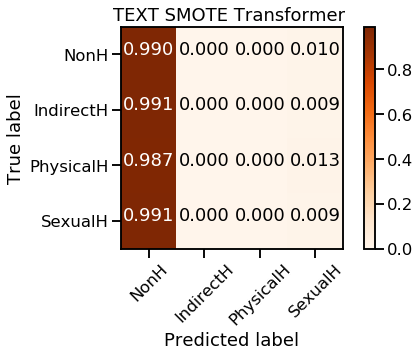

Test_ acc: 0.7479981158737635
Test_ f1 none: [0.856 0.    0.    0.017]
Test_ f1 macro: 0.21817078762970504
class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 4  ------------------- 



--------------------------------------------------------
Trabajando en predicciones Transformer
--------------------------------------------------------

Entrenando Run # 4
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.140 	F-macro_val: 0.061
Epoch 10 	acc_val: 0.010 	F-macro_val: 0.005
Epoch 20 	acc_val: 0.000 	F-macro_val: 0.000
Testing run # 4
SE TUVIERON QUE REPETIR 21 EJEMPLOS


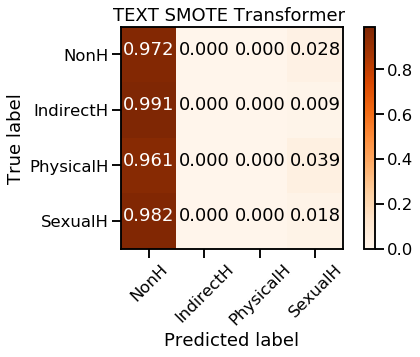

Test_ acc: 0.7357512953367875
Test_ f1 none: [0.848 0.    0.    0.03 ]
Test_ f1 macro: 0.21964181596751436


Nuevo best encontrado:

Acc: 0.736 	F1-ma: 0.220
	F1-none:  [0.848 0.    0.    0.03 ]
class_weights Training set [1. 1. 1. 1.]


 -------------------- Entrenando SMOTE exec 5  ------------------- 



--------------------------------------------------------
Trabajando en predicciones Transformer
--------------------------------------------------------

Entrenando Run # 5
Creando modelo con salida Softmax
Epoch 0 	acc_val: 0.237 	F-macro_val: 0.094
Epoch 10 	acc_val: 0.012 	F-macro_val: 0.006
Epoch 20 	acc_val: 0.000 	F-macro_val: 0.000
Testing run # 5
SE TUVIERON QUE REPETIR 21 EJEMPLOS


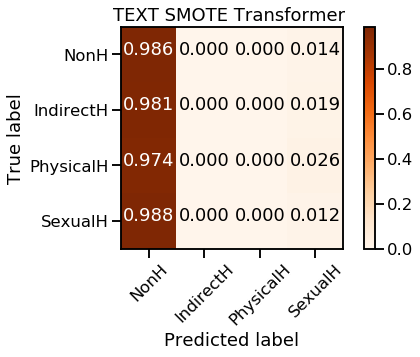

Test_ acc: 0.7451719265190768
Test_ f1 none: [0.855 0.    0.    0.022]
Test_ f1 macro: 0.21903827668430767


In [28]:
best_ma, glo_accs, glo_fno, glo_fma, glo_cms= train_5models_smote(7, 4, x_val, y_val, 1, 5, "Harassment", 26, "Oranges")

In [29]:
print ("best_50", best_ma)
print ("all_accs_50", glo_accs)
print ("all_fno_50", glo_fno)
print ("all_ma_50", glo_fma)
# best_ma, glo_accs, glo_fno, glo_fma, glo_cms

best_50 {'F_ma': 0.21964181596751436, 'Run': 4}
all_accs_50 [0.7409326424870466, 0.7517663683466792, 0.7479981158737635, 0.7357512953367875, 0.7451719265190768]
all_fno_50 [array([0.851, 0.   , 0.   , 0.026]), array([0.858, 0.   , 0.   , 0.006]), array([0.856, 0.   , 0.   , 0.017]), array([0.848, 0.   , 0.   , 0.03 ]), array([0.855, 0.   , 0.   , 0.022])]
all_ma_50 [0.21935071583793672, 0.21604926815386707, 0.21817078762970504, 0.21964181596751436, 0.21903827668430767]


Acc: 0.744 -- deviation: 0.006
F-score: 0.218 -- deviation: 0.001
(SMOTE) NIPS: 0.853661503722735 0.0 0.0 0.020139187695929744


Confusion counts
[[7.882e+03 0.000e+00 0.000e+00 1.230e+02]
 [5.260e+02 0.000e+00 0.000e+00 4.000e+00]
 [3.720e+02 0.000e+00 0.000e+00 8.000e+00]
 [1.681e+03 0.000e+00 0.000e+00 1.900e+01]]


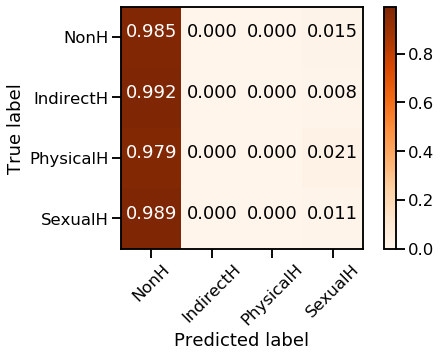

In [30]:
#best_15, all_accs, all_fno, all_ma, all_cm
print ("Acc: %.3f" % np.mean(np.asarray(glo_accs)), "-- deviation: %.3f" % np.std(np.asarray(glo_accs)))
print ("F-score: %.3f" % np.mean(np.asarray(glo_fma)), "-- deviation: %.3f" % np.std(np.asarray(glo_fma)))
np.set_printoptions(precision=3)
sup=np.mean(np.asarray(glo_fno)[:,0])
den=np.mean(np.asarray(glo_fno)[:,1])
que=np.mean(np.asarray(glo_fno)[:,2])
com=np.mean(np.asarray(glo_fno)[:,3])

print ("(SMOTE) NIPS:", sup,den,que,com)

print ("\n\nConfusion counts")
m_temp=np.zeros((4,4))
for m in glo_cms:
    m_temp+=np.asarray(m)
    
print (m_temp)

plot_cm(cm_norma(m_temp),["NonH", "IndirectH", "PhysicalH", "SexualH"], "", cmap='Oranges')